Import the necessary packages

In [1]:
import os, sys, re, json, time
from collections import Counter
import pandas as pd
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from keras import models
from keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from keras.utils import to_categorical
%matplotlib inline

sys.path.insert(0, os.path.abspath('./utils/'))
import utils

Using TensorFlow backend.
/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Some memory clean-up
K.clear_session()

Directory that stores the ASM files

In [3]:
asm_files_dir = '../dataset_asm_files_subset/'

In [4]:
asm_files = sorted(os.listdir(asm_files_dir))

Further processing, beyond that done by `utils.read_file()` and `utils.cleanse_lines()`

In [5]:
def process_dataset(line_arr):
    processed_line_arr = [ line for line in line_arr if (not (utils.is_text_comment(line[0]) or utils.is_data_comment(line[0]))) ]
    processed_line_arr = [ line for line in processed_line_arr if (not (line[0].startswith('assume'))) ]
    processed_line_arr = [ utils.separate_symbols('[', line) for line in processed_line_arr ]
    processed_line_arr = [ utils.separate_symbols(']', line) for line in processed_line_arr ]
    processed_line_arr = [ utils.separate_symbols('+', line) for line in processed_line_arr ]
    processed_line_arr = [ utils.separate_symbols('-', line) for line in processed_line_arr ]
    processed_line_arr = [ utils.separate_symbols('(', line) for line in processed_line_arr ]
    processed_line_arr = [ utils.separate_symbols(')', line) for line in processed_line_arr ]
    processed_line_arr = [ [token for token in line if token] for line in processed_line_arr ]
    processed_line_arr = [ ['addr' if utils.is_addr_label(token) else token for token in line] for line in processed_line_arr ]
    processed_line_arr = [ ['num' if utils.is_num_value(token) else token for token in line] for line in processed_line_arr ]
    return processed_line_arr

Read in the contents of the ASM file and extract the text segments (Done by `utils.read_file()`)

In [6]:
start_dataset_arr = time.time()

dataset_arr = [struct_dict for struct_dict in map(lambda x: utils.read_file(os.path.join(asm_files_dir, x)), asm_files)]

end_dataset_arr = time.time()

In [7]:
print(end_dataset_arr - start_dataset_arr)

388.06805634498596


Split the lines in the text segment using whitespace characters as the delimiter, and remove unnecessary tokens from the text segment (i.e. Anything that is not an opcode or an operand) (Done by `utils.cleanse_lines()`)

In [8]:
start_dataset_arr2 = time.time()

dataset_arr_2 = [{ 
    "text_arr": utils.cleanse_lines(struct_dict["text_arr"], 'text'), 
    "file_name": struct_dict["file_name"] 
} for struct_dict in dataset_arr]

end_dataset_arr2 = time.time()

In [9]:
print(end_dataset_arr2 - start_dataset_arr2)

1136.2145249843597


Apply the further processing (Replace numerical values with generic 'num' and addresses / labels with 'addr', etc.)

In [10]:
start_dataset_arr3 = time.time()

dataset_arr_3 = [{ 
    "text_arr": process_dataset(struct_dict["text_arr"]), 
    "file_name": struct_dict["file_name"] 
} for struct_dict in dataset_arr_2]

end_dataset_arr3 = time.time()

In [11]:
print(end_dataset_arr3 - start_dataset_arr3)

1084.0979585647583


By this time, the dataset more or less contains only opcodes and operands (what we need in the end)

In [12]:
dataset_arr_3[0]["file_name"]

'./dataset/asm_files_1086/01IsoiSMh5gxyDYTl4CB.asm'

In [13]:
dataset_arr_3[0]["text_arr"]

[['mov', 'dword', 'ptr', '[', 'ecx', ']', 'offset', 'off_5C0424'],
 ['jmp', 'addr'],
 ['align', 'num'],
 ['addr', 'proc', 'near'],
 ['arg_0', '=', 'byte', 'ptr', 'num'],
 ['push', 'esi'],
 ['mov', 'esi', 'ecx'],
 ['mov', 'dword', 'ptr', '[', 'esi', ']', 'offset', 'off_5C0424'],
 ['call', 'addr'],
 ['test', '[', 'esp', '+', 'num', 'arg_0', ']', 'num'],
 ['jz', 'short', 'addr'],
 ['push', 'esi'],
 ['call'],
 ['add', 'esp', 'num'],
 ['addr'],
 ['mov', 'eax', 'esi'],
 ['pop', 'esi'],
 ['retn', 'num'],
 ['addr', 'endp'],
 ['align', 'num'],
 ['addr'],
 ['xor', 'eax', 'eax'],
 ['retn', 'num'],
 ['align', 'num'],
 ['addr', 'proc', 'near'],
 ['mov', 'dl', '[', 'ecx', '+', 'num', ']'],
 ['and', '[', 'ecx', '+', 'num', ']', 'dl'],
 ['mov', 'eax', '[', 'ecx', '+', 'num', ']'],
 ['sub', 'eax', 'num'],
 ['mov', '[', 'ecx', '+', 'num', ']', 'eax'],
 ['mov', 'al', '[', 'ecx', '+', 'num', ']'],
 ['mov', 'dl', 'num'],
 ['sub', 'dl', '[', 'ecx', '+', 'num', ']'],
 ['add', 'al', 'num'],
 ['mov', '[', 'ecx

Flatten each line_arr, which contains the individual tokens (opcodes and operands), so that text_arr contains token_arrs instead of line_arrs

In [14]:
dataset_arr_3_flattened = [[ token for line_arr in struct_dict['text_arr'] for token in line_arr ] for struct_dict in dataset_arr_3]

Take the first 200 tokens from each file (more specifically from the text segment of each files)

In [15]:
dataset_arr_4 = [ token_arr[:200] for token_arr in dataset_arr_3_flattened ]

In [16]:
dataset_arr_4 = [ token_arr for token_arr in dataset_arr_4 if token_arr ]

In [17]:
print('Max. number of tokens per file:', max([ len(token_arr) for token_arr in dataset_arr_4 ]))
print('Min. number of tokens per file:', min([ len(token_arr) for token_arr in dataset_arr_4 ]))

Max. number of tokens per file: 200
Min. number of tokens per file: 200


Based on the tokens retrieved, generate a keyword dictionary to map unique tokens found in the dataset to index values.<br/>
E.g. mov - 1, push - 2, etc.

In [18]:
tokens = [ token for token_arr in dataset_arr_4 for token in token_arr ]

In [19]:
tokens_count = Counter(tokens)

In [20]:
keyword_mapping = { token: (index+1) for index, token in enumerate(tokens_count) }

In [21]:
keyword_mapping

{'mov': 1,
 'dword': 2,
 'ptr': 3,
 '[': 4,
 'ecx': 5,
 ']': 6,
 'offset': 7,
 'off_5C0424': 8,
 'jmp': 9,
 'addr': 10,
 'align': 11,
 'num': 12,
 'proc': 13,
 'near': 14,
 'arg_0': 15,
 '=': 16,
 'byte': 17,
 'push': 18,
 'esi': 19,
 'call': 20,
 'test': 21,
 'esp': 22,
 '+': 23,
 'jz': 24,
 'short': 25,
 'add': 26,
 'eax': 27,
 'pop': 28,
 'retn': 29,
 'endp': 30,
 'xor': 31,
 'dl': 32,
 'and': 33,
 'sub': 34,
 'al': 35,
 'edx': 36,
 'ax': 37,
 'dword_401000': 38,
 'dd': 39,
 'db': 40,
 'byte_401109': 41,
 'unk_562B25': 42,
 '_atexit': 43,
 'unk_562B24': 44,
 'dword_5624C4': 45,
 'dword_5624A4': 46,
 'jnz': 47,
 'dwFlags': 48,
 'dword_562460': 49,
 'cmp': 50,
 'jge': 51,
 'dword_562474': 52,
 'jle': 53,
 'dword_562470': 54,
 'dword_56241C': 55,
 'lea': 56,
 '-': 57,
 'retf': 58,
 'dup': 59,
 '(': 60,
 ')': 61,
 'sub_10001000': 62,
 'var_2C': 63,
 'var_28': 64,
 'var_C': 65,
 'var_4': 66,
 'arg_4': 67,
 'arg_8': 68,
 'SEH_10001000': 69,
 'large': 70,
 'fs:0': 71,
 'public': 72,
 'RunP

In [22]:
dataset_arr_5 = [{ 
    "text_arr": [ token for line_arr in struct_dict['text_arr'] for token in line_arr ], 
    "file_name": struct_dict["file_name"] 
} for struct_dict in dataset_arr_3]

In [23]:
data_labels = { filename: label for filename, label in pd.read_csv('./trainLabels.csv').get_values() }

In [24]:
data_labels = { filename: (label if label == 1 or label == 2 or label == 3 else 4 if label == 8 else 5 if label == 9 else None) for filename, label in data_labels.items() }

In [25]:
data_labels = { filename: label for filename, label in data_labels.items() if label is not None }

In [26]:
dataset_arr_5 = [{ 
    "text_arr": struct_dict["text_arr"], 
    "file_name": os.path.splitext(os.path.basename(struct_dict["file_name"]))[0]
} for struct_dict in dataset_arr_5]

In [27]:
dataset_arr_5 = [ struct_dict for struct_dict in dataset_arr_5 if data_labels.get(struct_dict['file_name'], None)  ]

In [28]:
dataset_arr_6 = [{ 
    "text_arr": struct_dict['text_arr'][:200], 
    "file_name": struct_dict["file_name"] 
} for struct_dict in dataset_arr_5]

In [29]:
dataset_arr_6 = [{ 
    "text_arr": struct_dict['text_arr'], 
    "file_name": struct_dict["file_name"] 
} for struct_dict in dataset_arr_6 if struct_dict['text_arr']]

In [30]:
train_set_size = round(0.7 * len(dataset_arr_5))

In [31]:
train_set = dataset_arr_6[:train_set_size]
test_set = dataset_arr_6[train_set_size:]

train_label = dataset_arr_6[:train_set_size]
test_label = dataset_arr_6[train_set_size:]

In [32]:
train_set = [ struct_dict['text_arr'] for struct_dict in train_set ]
test_set = [ struct_dict['text_arr'] for struct_dict in test_set ]

train_label = [ struct_dict['file_name'] for struct_dict in train_label ]
test_label = [ struct_dict['file_name'] for struct_dict in test_label ]

In [33]:
train_labels = [ data_labels.get(filename, filename) for filename in train_label ]
test_labels = [ data_labels.get(filename, filename) for filename in test_label ]

In [34]:
train_labels = [ (i - 1) for i in train_labels ]
test_labels = [ (i - 1) for i in test_labels ]

In [35]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [36]:
train_set = [ [keyword_mapping.get(token, token) for token in token_arr] for token_arr in train_set ]

In [37]:
test_set = [ [keyword_mapping.get(token, token) for token in token_arr] for token_arr in test_set ]

In [38]:
label_mappings = { (label-1): malware_family for label, malware_family in pd.read_csv('./label_mappings.csv').get_values() }

In [39]:
train_set_count = { label_mappings.get(val[0], val[0]): val[1] for val in Counter(np.argmax(train_labels, axis=1)).items() }
test_set_count = { label_mappings.get(val[0], val[0]): val[1] for val in Counter(np.argmax(test_labels, axis=1)).items() }

In [40]:
train_set_count

{'Kelihos_ver3': 229, 'Lollipop': 180, 'Ramnit': 100, 'Simda': 68, 'Vundo': 81}

In [41]:
test_set_count

{'Kelihos_ver3': 85, 'Lollipop': 80, 'Ramnit': 39, 'Simda': 32, 'Vundo': 32}

In [42]:
# x_train = np.zeros(shape=(len(train_set), 200, max(keyword_mapping.values()) + 1))

In [43]:
# x_train.shape

In [44]:
# for i, token_arr in enumerate(train_set):
#     for j, token in enumerate(token_arr):
#         if type(i) != int or type(j) != int or type(token) != int:
#             print(i, j, token)
#         x_train[i, j, token] = 1

In [45]:
# y_train = np.zeros(shape=(len(test_set), 200, max(keyword_mapping.values()) + 1))

In [46]:
# y_train.shape

In [47]:
# for i, token_arr in enumerate(test_set):
#     for j, token in enumerate(token_arr):
#         if type(i) != int or type(j) != int or type(token) != int:
#             print(i, j, token)
#         y_train[i, j, token] = 1

In [48]:
def get_model():
    model = models.Sequential()
    
    model.add(layers.Embedding(len(keyword_mapping), 32))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', 
                  metrics=['acc'])
    
    return model

In [49]:
classifier = KerasClassifier(build_fn=get_model, epochs=20, batch_size=10)

In [50]:
kfold = KFold(n_splits=4)

In [51]:
np.argmax(train_labels, axis=1).shape

(658,)

In [52]:
train_labels.shape

(658, 5)

In [53]:
# results = cross_val_score(classifier, train_set, train_labels, cv=kfold)

In [54]:
k = 4
num_val_samples = len(train_set) // k
num_epochs = 20
all_histories = []

In [55]:
x_train = np.array([ np.array(token_arr) for token_arr in train_set ])

In [56]:
x_test = np.array([ np.array(token_arr) for token_arr in test_set ])

In [57]:
for i in range(k):
    print('Processing fold #', i)
    val_set = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples], 
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_labels = np.concatenate(
        [train_labels[:i * num_val_samples],
         train_labels[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = get_model()
    history = model.fit(partial_x_train, partial_train_labels, 
                       batch_size=16, epochs=num_epochs, 
                       validation_data=(val_set, val_labels))  #  , verbose=0 is used to train the model in silent mode
    all_histories.append(history)
    print('Processed fold #', i)
    print('\n')

Processing fold # 0
Train on 494 samples, validate on 164 samples
Epoch 1/20
494/494 [==============================] - 13s - loss: 1.4722 - acc: 0.4514 - val_loss: 1.3016 - val_acc: 0.5061
Epoch 2/20
494/494 [==============================] - 9s - loss: 1.2212 - acc: 0.5223 - val_loss: 1.0218 - val_acc: 0.6402
Epoch 3/20
494/494 [==============================] - 10s - loss: 1.0746 - acc: 0.5891 - val_loss: 0.9541 - val_acc: 0.6585
Epoch 4/20
494/494 [==============================] - 10s - loss: 1.0137 - acc: 0.6012 - val_loss: 0.9562 - val_acc: 0.6646
Epoch 5/20
494/494 [==============================] - 10s - loss: 1.0021 - acc: 0.5972 - val_loss: 0.9317 - val_acc: 0.6646
Epoch 6/20
494/494 [==============================] - 10s - loss: 1.0253 - acc: 0.5850 - val_loss: 0.9338 - val_acc: 0.6524
Epoch 7/20
494/494 [==============================] - 10s - loss: 0.9532 - acc: 0.6012 - val_loss: 0.8625 - val_acc: 0.6646
Epoch 8/20
494/494 [==============================] - 10s - loss: 0

In [58]:
all_accuracies = [ history.history['acc'] for history in all_histories ]
all_val_accuracies = [ history.history['val_acc'] for history in all_histories ]
all_losses = [ history.history['loss'] for history in all_histories ]
all_val_losses = [ history.history['val_loss'] for history in all_histories ]

In [59]:
average_acc_history = [
    np.mean([accs[i] for accs in all_accuracies]) for i in range(num_epochs)
]
average_val_acc_history = [
    np.mean([val_accs[i] for val_accs in all_val_accuracies]) for i in range(num_epochs)
]
average_loss_history = [
    np.mean([loss[i] for loss in all_losses]) for i in range(num_epochs)
]
average_val_loss_history = [
    np.mean([val_loss[i] for val_loss in all_val_losses]) for i in range(num_epochs)
]

In [60]:
epochs = range(1, len(average_acc_history) + 1)

<Figure size 432x288 with 0 Axes>

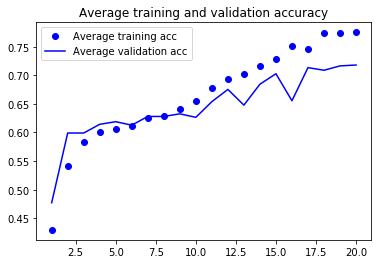

<Figure size 432x288 with 0 Axes>

In [61]:
plt.plot(epochs, average_acc_history, 'bo', label='Average training acc')
plt.plot(epochs, average_val_acc_history, 'b', label='Average validation acc')
plt.title('Average training and validation accuracy')
plt.legend()

plt.figure()

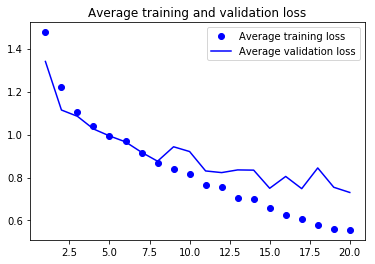

In [62]:
plt.plot(epochs, average_loss_history, 'bo', label='Average training loss')
plt.plot(epochs, average_val_loss_history, 'b', label='Average validation loss')
plt.title('Average training and validation loss')
plt.legend()

plt.show()

In [63]:
model = get_model()
model.fit(x_train, train_labels, epochs=20, batch_size=16)

Epoch 1/20
658/658 [==============================] - 13s - loss: 1.4921 - acc: 0.3541    
Epoch 2/20
658/658 [==============================] - 12s - loss: 1.2691 - acc: 0.5729    
Epoch 3/20
658/658 [==============================] - 12s - loss: 1.1148 - acc: 0.5942    
Epoch 4/20
658/658 [==============================] - 13s - loss: 1.0072 - acc: 0.6064    
Epoch 5/20
658/658 [==============================] - 12s - loss: 0.9534 - acc: 0.6292    
Epoch 6/20
658/658 [==============================] - 12s - loss: 0.8960 - acc: 0.6733    
Epoch 7/20
658/658 [==============================] - 12s - loss: 0.8290 - acc: 0.7006    
Epoch 8/20
658/658 [==============================] - 12s - loss: 0.8303 - acc: 0.7188    
Epoch 9/20
658/658 [==============================] - 12s - loss: 0.7589 - acc: 0.7310    
Epoch 10/20
658/658 [==============================] - 12s - loss: 0.7779 - acc: 0.7295    
Epoch 11/20
658/658 [==============================] - 12s - loss: 0.6711 - acc: 0.7796  

In [64]:
predicted_labels = model.predict_classes(x_test, batch_size=16)

268/268 [==============================] - 1s     


In [65]:
predicted_labels

array([0, 0, 2, 3, 2, 2, 3, 0, 2, 2, 1, 3, 2, 1, 3, 0, 2, 3, 1, 0, 1, 2,
       3, 1, 0, 1, 1, 1, 3, 1, 0, 0, 0, 1, 1, 1, 2, 2, 1, 2, 3, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 4, 0, 0, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 0,
       1, 2, 0, 2, 3, 0, 2, 2, 2, 2, 2, 1, 3, 3, 2, 3, 1, 0, 3, 1, 1, 1,
       2, 2, 2, 0, 2, 3, 0, 0, 1, 2, 3, 3, 2, 1, 3, 3, 2, 3, 2, 0, 0, 4,
       0, 2, 0, 2, 2, 3, 1, 1, 1, 2, 1, 1, 2, 3, 2, 1, 2, 1, 2, 2, 3, 2,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 3, 0, 2, 2, 2, 2, 1, 3, 0, 2, 0,
       2, 2, 2, 2, 0, 0, 2, 0, 3, 1, 3, 2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 2, 2, 0, 2, 0, 3, 3, 2, 1, 1, 0, 0, 3, 2, 1, 1, 0, 3, 1, 1,
       3, 3, 0, 1, 3, 1, 4, 1, 2, 1, 1, 3, 3, 1, 2, 0, 2, 2, 3, 1, 3, 2,
       3, 1, 2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 4, 0, 2, 2, 1, 0, 2, 1, 2, 1,
       3, 1, 3, 0, 3, 0, 2, 1, 0, 1, 2, 3, 0, 0, 1, 2, 0, 2, 3, 2, 2, 0,
       1, 1, 2, 1])

In [66]:
test_labels_original = np.argmax(test_labels, axis=1)

In [67]:
y_true = pd.Series(test_labels_original)
y_pred = pd.Series(predicted_labels)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,All
True,,,,,,
0,32,2,0,4,1,39
1,2,78,0,0,0,80
2,0,0,83,2,0,85
3,8,0,0,24,0,32
4,14,0,2,13,3,32
All,56,80,85,43,4,268


In [68]:
loss, accuracy = model.evaluate(x_test, test_labels)

268/268 [==============================] - 1s     


In [71]:
print('Accuracy :', accuracy)
print('Loss     :', loss)

Accuracy : 0.8208955223880597
Loss     : 0.5017762735708436
